# Compare Fast Net GP and Fast Lattice GP + Plot

In [1]:
import fastgp
import qmcpy as qp
import numpy as np
import torch
import pandas as pd
from matplotlib import pyplot
import tueplots.figsizes

In [2]:
torch.set_default_dtype(torch.float64)
device = "cpu"

In [3]:
colors = ["xkcd:"+color[:-1] for color in pd.read_csv("../../../xkcd_colors.txt",comment="#").iloc[:,0].tolist()][::-1]
_alpha = 0.25
WIDTH = 2*(500/72)
LINEWIDTH = 3
MARKERSIZE = 100

## True Function

In [4]:
d = 1
def f_ackley(x, a=20, b=0.2, c=2*np.pi, scaling=32.768):
    # https://www.sfu.ca/~ssurjano/ackley.html
    assert x.ndim==2
    x = 2*scaling*x-scaling
    t1 = a*torch.exp(-b*torch.sqrt(torch.mean(x**2,1)))
    t2 = torch.exp(torch.mean(torch.cos(c*x),1))
    t3 = a+np.exp(1)
    y = -t1-t2+t3
    return y
fs = [lambda x: f_ackley(x,c=0), lambda x: f_ackley(x)]
num_tasks = len(fs)
n = torch.tensor([2**4,2**3])

## Parameters

In [5]:
seqs_lattice = [qp.Lattice(1,seed=7),qp.Lattice(1,seed=2)]
seqs_dnb2s = [qp.DigitalNetB2(1,seed=7,randomize="DS"),qp.DigitalNetB2(1,seed=2,randomize="DS")]

FGPClasses = [fastgp.FastGPLattice,fastgp.FastGPDigitalNetB2]

xticks = torch.linspace(0,1,1001,device=device)[1:-1,None]
yticks = torch.vstack([fs[i](xticks) for i in range(num_tasks)])

## Independent Single Task GPs

In [6]:
pmeans = [torch.empty((num_tasks,len(xticks))) for i in range(2)]
ci_lows = [torch.empty((num_tasks,len(xticks))) for i in range(2)]
ci_highs = [torch.empty((num_tasks,len(xticks))) for i in range(2)]
fgp_indep = [[FGPClass(seqs=seqs[l],device=device) for l in range(num_tasks)] for FGPClass,seqs in zip(FGPClasses,[seqs_lattice,seqs_dnb2s])]
for i in range(2):
    for l in range(num_tasks):
        x_next = fgp_indep[i][l].get_x_next(n=n[l].item())
        y_next = torch.vstack([fs[i](x_next) for i in range(num_tasks)])
        fgp_indep[i][l].add_y_next(y_next[l])
        fgp_indep[i][l].fit()
        pmeans[i][l],_,_,ci_lows[i][l],ci_highs[i][l] = fgp_indep[i][l].post_ci(xticks)

     iter of 5.0e+03 | NMLL       | norm term  | logdet term
    ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
            0.00e+00 | 1.32e+03   | 1.32e+03   | -3.04e+01 
            5.00e+00 | 3.91e+02   | 3.69e+02   | -7.34e+00 
            1.00e+01 | 1.07e+02   | 2.72e+01   | 5.01e+01  
            1.50e+01 | 9.40e+01   | 2.79e+01   | 3.67e+01  
            2.00e+01 | 8.90e+01   | 1.29e+01   | 4.67e+01  
            2.50e+01 | 8.60e+01   | 1.83e+01   | 3.83e+01  
            3.00e+01 | 8.42e+01   | 1.55e+01   | 3.93e+01  
            3.50e+01 | 8.41e+01   | 1.56e+01   | 3.91e+01  
            4.00e+01 | 8.41e+01   | 1.53e+01   | 3.94e+01  
            4.50e+01 | 8.41e+01   | 1.60e+01   | 3.87e+01  
     iter of 5.0e+03 | NMLL       | norm term  | logdet term
    ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
            0.00e+00 | 8.01e+02   | 7.88e+02   | -2.24e+00 
            5.00e+00 | 2.85e+02   | 2.62e+02   | 8.92e+00  
            1.00e+01 | 7.88e+01   | 

## Multi-Task Fast GPs

In [7]:
fgp_multitask = [FGPClass(seqs=seqs,num_tasks=num_tasks,device=device) for FGPClass,seqs in zip(FGPClasses,[seqs_lattice,seqs_dnb2s])]
pmean_mt = [None for i in range(2)]
ci_low_mt = [None for i in range(2)]
ci_high_mt = [None for i in range(2)]
for i in range(2):
    x_next = fgp_multitask[i].get_x_next(n=n)
    y_next = [fs[i](x_next[i]) for i in range(num_tasks)]
    fgp_multitask[i].add_y_next(y_next)
    fgp_multitask[i].fit()
    pmean_mt[i],_,_,ci_low_mt[i],ci_high_mt[i] = fgp_multitask[i].post_ci(xticks)

     iter of 5.0e+03 | NMLL       | norm term  | logdet term
    ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
            0.00e+00 | 8.38e+02   | 8.13e+02   | -1.83e+01 
            5.00e+00 | 1.70e+02   | 8.80e+01   | 3.75e+01  
            1.00e+01 | 1.33e+02   | 2.52e+01   | 6.37e+01  
            1.50e+01 | 1.14e+02   | 2.56e+01   | 4.47e+01  
            2.00e+01 | 1.09e+02   | 2.47e+01   | 4.03e+01  
            2.50e+01 | 1.08e+02   | 2.76e+01   | 3.60e+01  
            3.00e+01 | 1.06e+02   | 2.39e+01   | 3.80e+01  
            3.50e+01 | 1.06e+02   | 2.39e+01   | 3.78e+01  
            4.00e+01 | 1.06e+02   | 2.43e+01   | 3.74e+01  
            4.30e+01 | 1.06e+02   | 2.45e+01   | 3.72e+01  
     iter of 5.0e+03 | NMLL       | norm term  | logdet term
    ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
            0.00e+00 | 5.20e+02   | 4.59e+02   | 1.70e+01  
            5.00e+00 | 1.73e+02   | 5.58e+01   | 7.35e+01  
            1.00e+01 | 1.58e+02   | 

## Plot

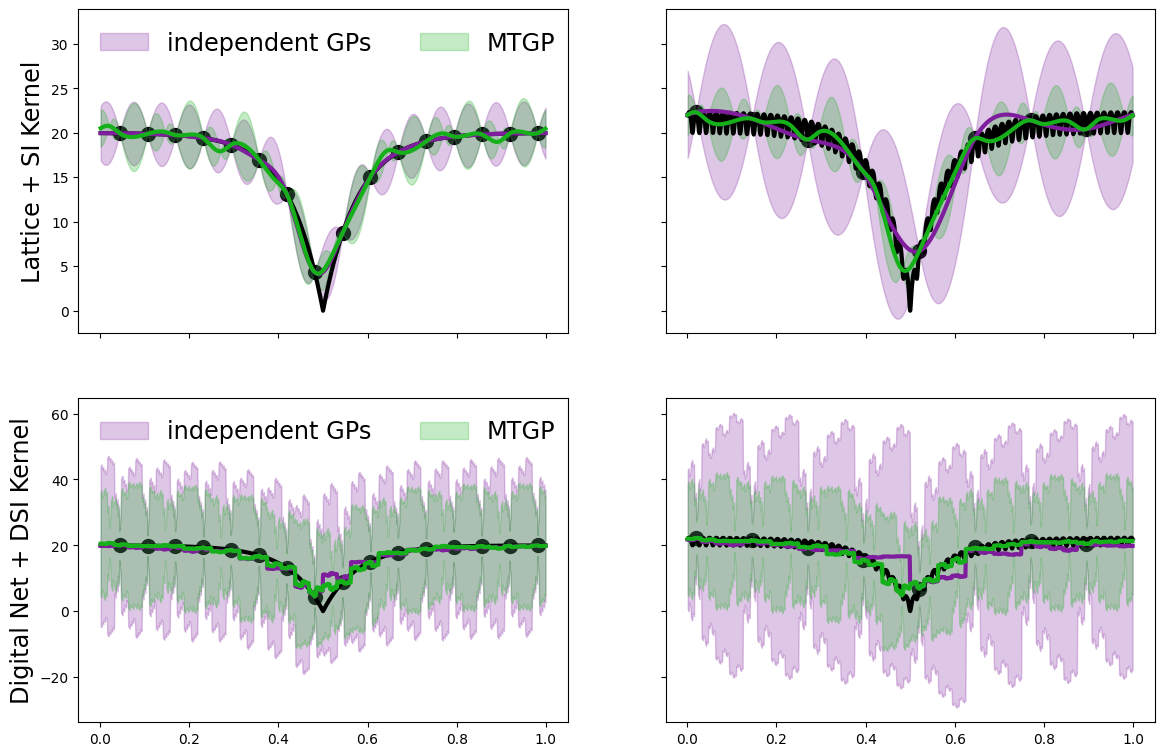

In [8]:
fig,ax = pyplot.subplots(nrows=2,ncols=num_tasks,figsize=(WIDTH,WIDTH/num_tasks*2/1.5),sharex=True,sharey="row")
ax = ax.reshape((2,num_tasks))
for i in range(2):
    for l in range(num_tasks):
        ax[i,l].plot(xticks[:,0].cpu(),yticks[l].cpu(),color="k",linewidth=LINEWIDTH)
        ax[i,l].scatter(fgp_indep[i][l].x[:,0].cpu(),fgp_indep[i][l].y.cpu(),color="k",s=MARKERSIZE)
    pltmin = min([ci_lows[i][l].min() for l in range(num_tasks)]+[ci_low_mt[i].min()])
    pltmax = max([ci_highs[i][l].max() for l in range(num_tasks)]+[ci_high_mt[i].max()])
    ax[i,0].set_ylim([pltmin-.05*(pltmax-pltmin),pltmax+.05*(pltmax-pltmin)])
ax[0,0].set_ylabel("Lattice + SI Kernel",fontsize="xx-large")
ax[1,0].set_ylabel("Digital Net + DSI Kernel",fontsize="xx-large")
fig.savefig("./fmtgp0.pdf",bbox_inches="tight")
for i in range(2):
    for l in range(num_tasks):
        ax[i,l].plot(xticks[:,0].cpu(),pmeans[i][l].cpu(),color=colors[0],linewidth=LINEWIDTH)
        ax[i,l].fill_between(xticks[:,0].cpu(),ci_lows[i][l].cpu(),ci_highs[i][l].cpu(),color=colors[0],alpha=_alpha,label="independent GPs")
    ax[i,0].legend(frameon=False,loc="upper left",ncols=2,fontsize="xx-large") 
fig.savefig("./fmtgp1.pdf",bbox_inches="tight")
for i in range(2):
    for l in range(num_tasks):
        ax[i,l].plot(xticks[:,0].cpu(),pmean_mt[i][l].cpu(),color=colors[1],linewidth=LINEWIDTH)
        ax[i,l].fill_between(xticks[:,0].cpu(),ci_low_mt[i][l].cpu(),ci_high_mt[i][l].cpu(),color=colors[1],alpha=_alpha,label="MTGP")
    ax[i,0].legend(frameon=False,loc="upper left",ncols=2,fontsize="xx-large") 
fig.savefig("./fmtgp2.pdf",bbox_inches="tight")